In [1]:
def unpaint_dataset():
    pass

import torchvision
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

def unpaint_center(images, mask_size=0.5):
    img_size = images.shape[-1]
    mask = torch.ones_like(images)
    mask[:, int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size), int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size)] = 0
    return torch.mul(images, mask)

def gaussian_blurring(images):
    import cv2
    Gaussian = cv2.GaussianBlur(images, (7, 7), 0)
    

batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

unpaint_center_transform =  transforms.Compose(
    [transforms.ToTensor(),
     unpaint_center,
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset_cifar, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

unpainted_trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=unpaint_center_transform)

testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


sample_images = next(iter(trainloader))[0]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


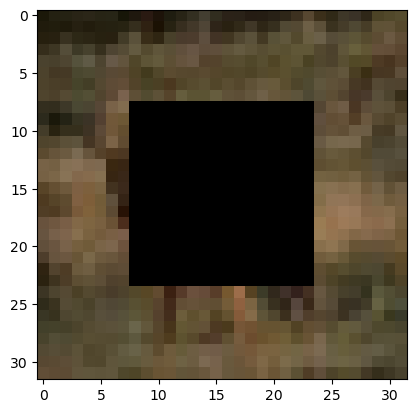

In [32]:
plt.imshow((unpainted_trainset_cifar[3][0].permute([1, 2, 0]) * 0.5 + 0.5))


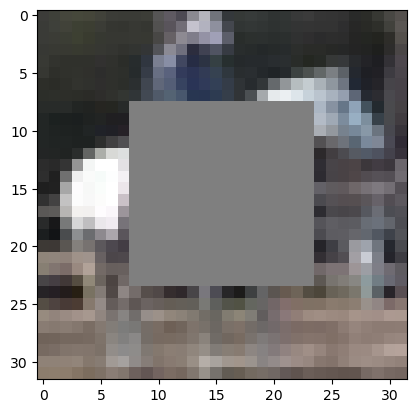

In [24]:
plt.imshow((unpaint_center(sample_images)[3].permute([1, 2, 0]) * 0.5 + 0.5))


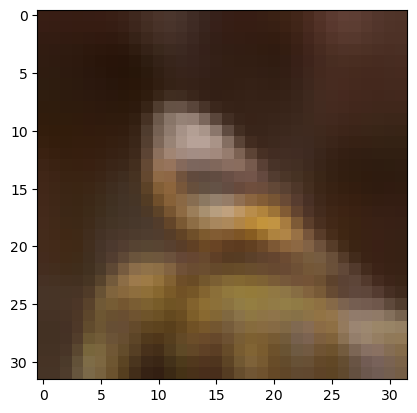

In [15]:

def gaussian_blurring(images):
    blurring_fn = torchvision.transforms.GaussianBlur(5, sigma=(0.1, 1.0))
    return blurring_fn(images)
    
gaussian_blurring(sample_images)
plt.imshow(gaussian_blurring(sample_images)[0].permute([1, 2, 0]) * 0.5 + 0.5)

In [28]:
celeba_transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((128, 128)),
                torchvision.transforms.Normalize([0.5],[0.5])
            ])
celeba_train = torchvision.datasets.CelebA('data', 'train', transform=celeba_transform, download=True)


Files already downloaded and verified


In [35]:
fig = plt.figure()
ax = fig1.add_subplot(1,1,1) 
ax.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)
plt.show()

/tmp/ipykernel_552640/926456421.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)


<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_552640/4004375251.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)


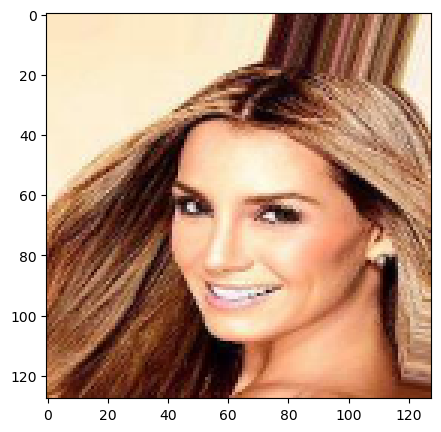

In [43]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)
# plt.show()